In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
# ATENCION /.\: Puede que no lea el csv si hay comas entre nombres de transportistas, etc (ELIMINAR LAS COMAS PRIMERO)
ruta = pd.read_csv('rechazos_ruta.csv')
print(ruta.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8104 entries, 0 to 8103
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Subregion Comercial         8104 non-null   object 
 1   Locación                    8104 non-null   object 
 2   Ruta Troncal Dinámico       8104 non-null   object 
 3   Ruta Figura Dinámico        8104 non-null   object 
 4   Sistema de Ventas Dinámico  8104 non-null   object 
 5   Supervisor                  6875 non-null   object 
 6   VendedorCod                 8104 non-null   int64  
 7   Motivo de anulación         8104 non-null   object 
 8   Número de Pedido            8104 non-null   int64  
 9   Número de orden de carga    8094 non-null   float64
 10  Número de Guía              8104 non-null   int64  
 11  Semana                      8104 non-null   int64  
 12  Mes                         8104 non-null   object 
 13  Año                         8104 

In [3]:
# eliminar todas las columnas excepto las relevantes
ruta = ruta[[
    'Locación',
    'Ruta Troncal Dinámico',
    'Motivo de anulación',
    'Día',
    'Venta Perdida CF',
    'Cliente',
    'Transportista',
    'Nombre Vendedor',
]]
print(ruta.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8104 entries, 0 to 8103
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Locación               8104 non-null   object 
 1   Ruta Troncal Dinámico  8104 non-null   object 
 2   Motivo de anulación    8104 non-null   object 
 3   Día                    8104 non-null   object 
 4   Venta Perdida CF       8104 non-null   float64
 5   Cliente                8104 non-null   object 
 6   Transportista          8104 non-null   object 
 7   Nombre Vendedor        8104 non-null   object 
dtypes: float64(1), object(7)
memory usage: 506.6+ KB
None


In [4]:
# conservar las filas que contenga las siguientes Locaciones (por si acaso lo normal es que no esten estas locaciones)
locaciones = ['06 AYA EL PEDREGAL', '38 AYA ATICO', '40 AYA CHALA', '88 AYA CAMANA']
ruta = ruta[ruta['Locación'].isin(locaciones)]
print(ruta.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8104 entries, 0 to 8103
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Locación               8104 non-null   object 
 1   Ruta Troncal Dinámico  8104 non-null   object 
 2   Motivo de anulación    8104 non-null   object 
 3   Día                    8104 non-null   object 
 4   Venta Perdida CF       8104 non-null   float64
 5   Cliente                8104 non-null   object 
 6   Transportista          8104 non-null   object 
 7   Nombre Vendedor        8104 non-null   object 
dtypes: float64(1), object(7)
memory usage: 506.6+ KB
None


In [5]:
# rellenar los valores NaN con 0
ruta = ruta.fillna(0)
print(ruta.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8104 entries, 0 to 8103
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Locación               8104 non-null   object 
 1   Ruta Troncal Dinámico  8104 non-null   object 
 2   Motivo de anulación    8104 non-null   object 
 3   Día                    8104 non-null   object 
 4   Venta Perdida CF       8104 non-null   float64
 5   Cliente                8104 non-null   object 
 6   Transportista          8104 non-null   object 
 7   Nombre Vendedor        8104 non-null   object 
dtypes: float64(1), object(7)
memory usage: 506.6+ KB
None


### ANALISIS

In [ ]:
''' ESCOGER QUE TIPO DE ANALISIS HACER
(1) Por Año (Escoger el año especifico) (Analisis de todo ese año)
(2) Por Mes (Escoger el mes especifico) (Analisis de todo ese mes)
(3) Por Día (Escoger el día especifico) (Analisis de todo ese día)
(4) Intervalo (Escoger fecha de inicio y fecha de fin especificas) (Analisis de todo el intervalo considerando las fechas ingresadas)
(5) Mayor igual que (Escoger fecha de inicio) (Analisis considerando esa fecha hasta el ultimo registro existente)
'''
# Establecer dia como tipo fecha
ruta['Día'] = pd.to_datetime(ruta['Día'], errors='coerce', dayfirst=True)

# Seleccionar la opcion de análisis por tiempo
opcion = int(input("(1=Año) (2=Mes) (3=Dia) (4=Intervalo) (5=Mayor igual que)"))
fecha = 0

if opcion == 1:
    fecha = input("año")
    fecha_inicio = pd.to_datetime('01/01/'+str(fecha), format='%d/%m/%Y')
    fecha_fin = pd.to_datetime('31/12/'+str(fecha), format='%d/%m/%Y')
    ruta = ruta[(ruta['Día'] >= fecha_inicio) & (ruta['Día'] <= fecha_fin)]
elif opcion == 2:
    fecha = input("mes/año")
    month, year = fecha.split('/')
    fecha_inicio = pd.to_datetime('01/'+str(month)+'/'+str(year), format='%d/%m/%Y')
    fecha_fin = pd.to_datetime('01/'+str(int(month)+1)+'/'+str(year), format='%d/%m/%Y')
    ruta = ruta[(ruta['Día'] >= fecha_inicio) & (ruta['Día'] < fecha_fin)]
elif opcion == 3:
    fecha = input("dia/mes/año")
    fecha_corte = pd.to_datetime(str(fecha), format='%d/%m/%Y')
    ruta = ruta[ruta['Día'] == fecha_corte]
elif opcion == 4:
    fecha = input("dia/mes/año dia/mes/año")
    fecha_inicio, fecha_fin = fecha.split(' ')
    fecha_inicio = pd.to_datetime(str(fecha_inicio), format='%d/%m/%Y')
    fecha_fin = pd.to_datetime(str(fecha_fin), format='%d/%m/%Y')
    ruta = ruta[(ruta['Día'] >= fecha_inicio) & (ruta['Día'] <= fecha_fin)]
elif opcion == 5:
    fecha = input("dia/mes/año")
    fecha_corte = pd.to_datetime(str(fecha), format='%d/%m/%Y')
    ruta = ruta[ruta['Día'] >= fecha_corte]

print(ruta.info())

C:\Users\AYACDA23\AppData\Local\Temp\ipykernel_13780\4074556981.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ruta['Día'] = pd.to_datetime(ruta['Día'], errors='coerce', dayfirst=True)


<class 'pandas.core.frame.DataFrame'>
Index: 233 entries, 7871 to 8103
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Locación               233 non-null    object        
 1   Ruta Troncal Dinámico  233 non-null    object        
 2   Motivo de anulación    233 non-null    object        
 3   Día                    233 non-null    datetime64[ns]
 4   Venta Perdida CF       233 non-null    float64       
 5   Cliente                233 non-null    object        
 6   Transportista          233 non-null    object        
 7   Nombre Vendedor        233 non-null    object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 16.4+ KB
None


In [7]:
# Veces rechazadas por motivo de anulación
# ruta['Motivo de anulación'].value_counts().plot(kind='bar', title='Top motivos de anulación')

def vc_motivo_anulacion():
    try:
        # Obtener los datos
        motivos_counts = ruta['Motivo de anulación'].value_counts()

        # Crear figura y ejes
        fig, ax = plt.subplots()

        # Graficar
        bars = motivos_counts.plot(
            kind='bar',
            title='Veces rechazadas por motivo de anulación',
            ax=ax,
            figsize=(10, 8)
        )

        total_motivos = 0
        # Agregar valores encima de cada barra
        for i, value in enumerate(motivos_counts.values):
            total_motivos = total_motivos + value
            ax.text(
                i,                      # posición X (índice de la barra)
                value + 0.2,            # posición Y (ligeramente encima del valor)
                str(value),             # texto (valor como string)
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Texto personalizado dentro del gráfico
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(total_motivos)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )

        # Mostrar gráfico
        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [8]:
# Venta perdida por motivo de anulación
#motivos_vp = ruta.groupby('Motivo de anulación')['Venta Perdida CF'].sum().sort_values(ascending=False)
#motivos_vp.plot(kind='bar', title='Cantidad de venta perdida por motivo')

def vp_motivo_anulacion():
    try:
        # Agrupar y ordenar
        motivos_vp = ruta.groupby('Motivo de anulación')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # Crear figura y eje
        fig, ax = plt.subplots()

        # Graficar
        bars = motivos_vp.plot(
            kind='bar',
            title='Venta Perdida por Motivo',
            ax=ax,
            figsize=(10, 8)
        )

        total_vp_motivos = 0
        # Agregar valores exactos encima de cada barra
        for i, value in enumerate(motivos_vp.values):
            total_vp_motivos = total_vp_motivos + value
            ax.text(
                i, value + (value * 0.01),  # posición X, Y
                f'{value:,.0f}$',            # formato con separador de miles, sin decimales
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Agregar nota dentro del gráfico (opcional)
        ax.text(
            0.98, 0.96,
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(round(total_vp_motivos, 2))), # texto a mostrar
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
        )

        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [9]:
# Veces rechazadas por transportista

def vc_transportista():
    try:
        # Obtener los datos
        transportista_counts = ruta['Transportista'].value_counts()

        # Crear figura y ejes
        fig, ax = plt.subplots()

        # Graficar
        bars = transportista_counts.plot(
            kind='bar',
            title='Veces rechazadas por transportista',
            ax=ax,
            figsize=(10, 8)
        )

        total_transportista = 0
        # Agregar valores encima de cada barra
        for i, value in enumerate(transportista_counts.values):
            total_transportista = total_transportista + value
            ax.text(
                i,                      # posición X (índice de la barra)
                value + 0.2,            # posición Y (ligeramente encima del valor)
                str(value),             # texto (valor como string)
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Texto personalizado dentro del gráfico
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(total_transportista)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )

        # Mostrar gráfico
        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [10]:
# Venta perdida por transportista
# ruta.groupby('Transportista')['Venta Perdida CF'].sum().sort_values(ascending=False).plot(kind='bar', title='Venta Perdida por Transportista')

def vp_transportista():
    try:
        # Agrupar y ordenar
        vp_transportista = ruta.groupby('Transportista')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # Crear figura y eje
        fig, ax = plt.subplots()

        # Graficar
        vp_transportista.plot(
            kind='bar',
            title='Venta Perdida por Transportista',
            ax=ax,
            figsize=(10, 8)
        )

        total_vp_transportista = 0
        # Agregar valores exactos encima de cada barra
        for i, value in enumerate(vp_transportista.values):
            total_vp_transportista = total_vp_transportista + value
            ax.text(
                i, value + (value * 0.01),       # posición Y: ligeramente arriba de la barra
                f'{value:,.0f}$',                 # formato: separador de miles, sin decimales
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Agregar nota dentro del gráfico (opcional)
        ax.text(
            0.98, 0.96,
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(round(total_vp_transportista, 2))), # texto a mostrar
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
        )

        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [11]:
# Veces rechazadas por ruta

def vc_ruta():
    try:
        # Obtener los datos
        ruta_counts = ruta['Ruta Troncal Dinámico'].value_counts()

        # Crear figura y ejes
        fig, ax = plt.subplots()

        # Graficar
        bars = ruta_counts.plot(
            kind='bar',
            title='Veces rechazadas por ruta',
            ax=ax,
            figsize=(10, 8)
        )

        total_ruta = 0
        # Agregar valores encima de cada barra
        for i, value in enumerate(ruta_counts.values):
            total_ruta = total_ruta + value
            ax.text(
                i,                      # posición X (índice de la barra)
                value + 0.2,            # posición Y (ligeramente encima del valor)
                str(value),             # texto (valor como string)
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Texto personalizado dentro del gráfico
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(total_ruta)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )

        # Mostrar gráfico
        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [12]:
# Venta perdida por ruta
# ruta.groupby('Ruta Troncal Dinámico')['Venta Perdida CF'].sum().sort_values(ascending=False).plot(kind='bar', title='Venta Perdida por Ruta')

def vp_ruta():
    try:
        # Agrupar y ordenar por venta perdida
        vp_ruta = ruta.groupby('Ruta Troncal Dinámico')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # Crear figura y eje
        fig, ax = plt.subplots()

        # Graficar
        vp_ruta.plot(
            kind='bar',
            title='Venta Perdida por Ruta',
            ax=ax,
            figsize=(10, 8)
        )

        total_vp_ruta = 0
        # Agregar etiquetas con valores exactos
        for i, value in enumerate(vp_ruta.values):
            total_vp_ruta = total_vp_ruta + value
            ax.text(
                i, value + (value * 0.01), # Y: un poco arriba de la barra
                f'{value:,.0f}$',           # formato con separadores de miles
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Agregar nota dentro del gráfico
        ax.text(
            0.98, 0.96,
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(round(total_vp_ruta, 2))), # texto a mostrar
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
        )

        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [13]:
# Veces rechazadas por cliente

def vc_cliente():
    try:
        # Obtener los datos
        cliente_counts = ruta['Cliente'].value_counts()

        # Crear figura y ejes
        fig, ax = plt.subplots()

        # Graficar
        bars = cliente_counts.plot(
            kind='bar',
            title='Veces rechazadas por cliente',
            ax=ax,
            figsize=(10, 8)
        )

        total_cliente = 0
        # Agregar valores encima de cada barra
        for i, value in enumerate(cliente_counts.values):
            total_cliente = total_cliente + value
            ax.text(
                i,                      # posición X (índice de la barra)
                value + 0.2,            # posición Y (ligeramente encima del valor)
                str(value),             # texto (valor como string)
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Texto personalizado dentro del gráfico
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(total_cliente)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )

        # Mostrar gráfico
        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [14]:
# Venta perdida por cliente
# clientes_vp = ruta.groupby('Cliente')['Venta Perdida CF'].sum().sort_values(ascending=False)
# clientes_vp.plot(kind='bar', title='Venta Perdida por Cliente')

def vp_cliente():
    try:
        # Agrupar y ordenar por venta perdida
        clientes_vp = ruta.groupby('Cliente')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # Crear figura y eje
        fig, ax = plt.subplots()

        # Graficar
        clientes_vp.plot(
            kind='bar',
            title='Venta Perdida por Cliente',
            ax=ax,
            figsize=(10, 8)
        )

        total_vp_cliente = 0
        # Agregar valores exactos sobre cada barra
        for i, value in enumerate(clientes_vp.values):
            total_vp_cliente = total_vp_cliente + value
            ax.text(
                i, value + (value * 0.01),
                f'{value:,.0f}$',  # Formato con separador de miles, sin decimales
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Agregar nota interna en el gráfico
        ax.text(
            0.98, 0.96,
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(round(total_vp_cliente, 2))), # texto a mostrar
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
        )

        # Mejorar presentación si los nombres de clientes son largos
        plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [15]:
# Veces rechazadas por vendedor

def vc_vendedor():
    try:
        # Obtener los datos
        vendedor_counts = ruta['Nombre Vendedor'].value_counts()

        # Crear figura y ejes
        fig, ax = plt.subplots()

        # Graficar
        bars = vendedor_counts.plot(
            kind='bar',
            title='Veces rechazadas por vendedor',
            ax=ax,
            figsize=(10, 8)
        )

        total_vendedor = 0
        # Agregar valores encima de cada barra
        for i, value in enumerate(vendedor_counts.values):
            total_vendedor = total_vendedor + value
            ax.text(
                i,                      # posición X (índice de la barra)
                value + 0.2,            # posición Y (ligeramente encima del valor)
                str(value),             # texto (valor como string)
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Texto personalizado dentro del gráfico
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(total_vendedor)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )

        # Mostrar gráfico
        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [16]:
# Venta perdida por vendedor

def vp_vendedor():
    try:
        # Agrupar y ordenar por venta perdida
        vendedor_vp = ruta.groupby('Nombre Vendedor')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # Crear figura y eje
        fig, ax = plt.subplots()

        # Graficar
        vendedor_vp.plot(
            kind='bar',
            title='Venta Perdida por Vendedor',
            ax=ax,
            figsize=(10, 8)
        )

        total_vp_vendedor = 0
        # Agregar valores exactos sobre cada barra
        for i, value in enumerate(vendedor_vp.values):
            total_vp_vendedor = total_vp_vendedor + value
            ax.text(
                i, value + (value * 0.01),
                f'{value:,.0f}$',  # Formato con separador de miles, sin decimales
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Agregar nota interna en el gráfico
        ax.text(
            0.98, 0.96,
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(round(total_vp_vendedor, 2))), # texto a mostrar
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
        )

        # Mejorar presentación si los nombres de clientes son largos
        plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [17]:
# Veces rechazadas por locacion

def vc_locacion():
    try:
        # Obtener los datos
        locacion_counts = ruta['Locación'].value_counts()

        # Crear figura y ejes
        fig, ax = plt.subplots()

        # Graficar
        bars = locacion_counts.plot(
            kind='bar',
            title='Veces rechazadas por locacion',
            ax=ax,
            figsize=(10, 8)
        )

        total_locacion = 0
        # Agregar valores encima de cada barra
        for i, value in enumerate(locacion_counts.values):
            total_locacion = total_locacion + value
            ax.text(
                i,                      # posición X (índice de la barra)
                value + 0.2,            # posición Y (ligeramente encima del valor)
                str(value),             # texto (valor como string)
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Texto personalizado dentro del gráfico
        ax.text(
            0.98, 0.96, # posición (x, y) relativa (de 0 a 1)
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(total_locacion)), # texto a mostrar
            transform=ax.transAxes,   # usa coordenadas relativas al eje
            ha='right', va='top',     # alineación del texto
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3') # fondo del texto
        )

        # Mostrar gráfico
        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [18]:
# Venta perdida por Locacion

def vp_locacion():
    try:
        # Agrupar y ordenar por venta perdida
        locacion_vp = ruta.groupby('Locación')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # Crear figura y eje
        fig, ax = plt.subplots()

        # Graficar
        locacion_vp.plot(
            kind='bar',
            title='Venta Perdida por Locacion',
            ax=ax,
            figsize=(10, 8)
        )

        total_vp_cliente = 0
        # Agregar valores exactos sobre cada barra
        for i, value in enumerate(locacion_vp.values):
            total_vp_cliente = total_vp_cliente + value
            ax.text(
                i, value + (value * 0.01),
                f'{value:,.0f}$',  # Formato con separador de miles, sin decimales
                ha='center', va='bottom',
                fontsize=9, color='black'
            )

        # Agregar nota interna en el gráfico
        ax.text(
            0.98, 0.96,
            ('Fecha: ' + str(fecha) + '\n\nTotal: ' + str(round(total_vp_cliente, 2))), # texto a mostrar
            transform=ax.transAxes,
            ha='right', va='top',
            fontsize=10,
            color='gray',
            bbox=dict(facecolor='white', edgecolor='gray', boxstyle='round,pad=0.3')
        )

        # Mejorar presentación si los nombres de clientes son largos
        plt.xticks(rotation=45, ha='right')

        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [19]:
# Venta perdida y cantidad por Motivo de anulacion

def vp_c_motivo_anulacion():
    try:
        group = ruta.groupby('Motivo de anulación')
        venta_perdida = group['Venta Perdida CF'].sum()
        cantidad = group.size()

        # Totales generales
        total_vp = venta_perdida.sum()
        total_cm = cantidad.sum()

        # Agrupar y ordenar por venta perdida y cantidad
        motivos = venta_perdida.sort_values(ascending=False).index
        venta_perdida = venta_perdida[motivos]
        cantidad = cantidad[motivos]

        # Preparar posiciones
        x = np.arange(len(motivos))
        width = 0.4

        # Graficar
        fig, ax = plt.subplots(figsize=(10, 6))
        bars1 = ax.bar(x - width/2, venta_perdida, width, label=f'Venta Perdida CF (Total: {round(total_vp, 2)})')
        bars2 = ax.bar(x + width/2, cantidad, width, label=f'Cantidad x Motivo (Total: {round(total_cm, 2)})')

        # Configurar etiquetas
        ax.set_xticks(x)
        ax.set_xticklabels(motivos, rotation=45, ha='right')
        ax.set_ylabel('Valores')
        ax.set_title('Venta Perdida y Cantidad por Motivos')
        ax.legend()

        # Agregar valores sobre las barras
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:,.0f}$',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        for bar in bars2:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [20]:
# Venta perdida y cantidad por Transportista

def vp_c_transportista():
    try:
        group = ruta.groupby('Transportista')
        venta_perdida = group['Venta Perdida CF'].sum()
        cantidad = group.size()

        # Totales generales
        total_vp = venta_perdida.sum()
        total_cm = cantidad.sum()

        # Agrupar y ordenar por venta perdida y cantidad
        transportistas = venta_perdida.sort_values(ascending=False).index
        venta_perdida = venta_perdida[transportistas]
        cantidad = cantidad[transportistas]

        # Preparar posiciones
        x = np.arange(len(transportistas))
        width = 0.4

        # Graficar
        fig, ax = plt.subplots(figsize=(10, 6))
        bars1 = ax.bar(x - width/2, venta_perdida, width, label=f'Venta Perdida CF (Total: {round(total_vp, 2)})')
        bars2 = ax.bar(x + width/2, cantidad, width, label=f'Cantidad x Transportista (Total: {round(total_cm, 2)})')

        # Configurar etiquetas
        ax.set_xticks(x)
        ax.set_xticklabels(transportistas, rotation=45, ha='right')
        ax.set_ylabel('Valores')
        ax.set_title('Venta Perdida y Cantidad por Transportista')
        ax.legend()

        # Agregar valores sobre las barras
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:,.0f}$',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        for bar in bars2:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [21]:
# Venta perdida y cantidad por Ruta

def vp_c_ruta():
    try:
        group = ruta.groupby('Ruta Troncal Dinámico')
        venta_perdida = group['Venta Perdida CF'].sum()
        cantidad = group.size()

        # Totales generales
        total_vp = venta_perdida.sum()
        total_cm = cantidad.sum()

        # Agrupar y ordenar por venta perdida y cantidad
        rutas = venta_perdida.sort_values(ascending=False).index
        venta_perdida = venta_perdida[rutas]
        cantidad = cantidad[rutas]

        # Preparar posiciones
        x = np.arange(len(rutas))
        width = 0.4

        # Graficar
        fig, ax = plt.subplots(figsize=(10, 6))
        bars1 = ax.bar(x - width/2, venta_perdida, width, label=f'Venta Perdida CF (Total: {round(total_vp, 2)})')
        bars2 = ax.bar(x + width/2, cantidad, width, label=f'Cantidad x Ruta (Total: {round(total_cm, 2)})')

        # Configurar etiquetas
        ax.set_xticks(x)
        ax.set_xticklabels(rutas, rotation=45, ha='right')
        ax.set_ylabel('Valores')
        ax.set_title('Venta Perdida y Cantidad por Ruta')
        ax.legend()

        # Agregar valores sobre las barras
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:,.0f}$',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        for bar in bars2:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [22]:
# Venta perdida y cantidad por Cliente

def vp_c_cliente():
    try:
        group = ruta.groupby('Cliente')
        venta_perdida = group['Venta Perdida CF'].sum()
        cantidad = group.size()

        # Totales generales
        total_vp = venta_perdida.sum()
        total_cm = cantidad.sum()

        # Agrupar y ordenar por venta perdida y cantidad
        cliente = venta_perdida.sort_values(ascending=False).index
        venta_perdida = venta_perdida[cliente]
        cantidad = cantidad[cliente]

        # Preparar posiciones
        x = np.arange(len(cliente))
        width = 0.4

        # Graficar
        fig, ax = plt.subplots(figsize=(10, 6))
        bars1 = ax.bar(x - width/2, venta_perdida, width, label=f'Venta Perdida CF (Total: {round(total_vp, 2)})')
        bars2 = ax.bar(x + width/2, cantidad, width, label=f'Cantidad x Cliente (Total: {round(total_cm, 2)})')

        # Configurar etiquetas
        ax.set_xticks(x)
        ax.set_xticklabels(cliente, rotation=45, ha='right')
        ax.set_ylabel('Valores')
        ax.set_title('Venta Perdida y Cantidad por Cliente')
        ax.legend()

        # Agregar valores sobre las barras
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:,.0f}$',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        for bar in bars2:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [23]:
# Venta perdida y cantidad por Vendedor

def vp_c_vendedor():
    try:
        group = ruta.groupby('Ruta Troncal Dinámico')
        venta_perdida = group['Venta Perdida CF'].sum()
        cantidad = group.size()

        # Totales generales
        total_vp = venta_perdida.sum()
        total_cm = cantidad.sum()

        # Agrupar y ordenar por venta perdida y cantidad
        vendedores = venta_perdida.sort_values(ascending=False).index
        venta_perdida = venta_perdida[vendedores]
        cantidad = cantidad[vendedores]

        # Preparar posiciones
        x = np.arange(len(vendedores))
        width = 0.4

        # Graficar
        fig, ax = plt.subplots(figsize=(10, 6))
        bars1 = ax.bar(x - width/2, venta_perdida, width, label=f'Venta Perdida CF (Total: {round(total_vp, 2)})')
        bars2 = ax.bar(x + width/2, cantidad, width, label=f'Cantidad x Vendedor (Total: {round(total_cm, 2)})')

        # Configurar etiquetas
        ax.set_xticks(x)
        ax.set_xticklabels(vendedores, rotation=45, ha='right')
        ax.set_ylabel('Valores')
        ax.set_title('Venta Perdida y Cantidad por Vendedor')
        ax.legend()

        # Agregar valores sobre las barras
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:,.0f}$',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        for bar in bars2:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [24]:
# Venta perdida y cantidad por Locacion

def vp_c_locacion():
    try:
        group = ruta.groupby('Locación')
        venta_perdida = group['Venta Perdida CF'].sum()
        cantidad = group.size()

        # Totales generales
        total_vp = venta_perdida.sum()
        total_cm = cantidad.sum()

        # Agrupar y ordenar por venta perdida y cantidad
        locaciones = venta_perdida.sort_values(ascending=False).index
        venta_perdida = venta_perdida[locaciones]
        cantidad = cantidad[locaciones]

        # Preparar posiciones
        x = np.arange(len(locaciones))
        width = 0.4

        # Graficar
        fig, ax = plt.subplots(figsize=(10, 6))
        bars1 = ax.bar(x - width/2, venta_perdida, width, label=f'Venta Perdida CF (Total: {round(total_vp, 2)})')
        bars2 = ax.bar(x + width/2, cantidad, width, label=f'Cantidad x Locacion (Total: {round(total_cm, 2)})')

        # Configurar etiquetas
        ax.set_xticks(x)
        ax.set_xticklabels(locaciones, rotation=45, ha='right')
        ax.set_ylabel('Valores')
        ax.set_title('Venta Perdida y Cantidad por Locación')
        ax.legend()

        # Agregar valores sobre las barras
        for bar in bars1:
            height = bar.get_height()
            ax.annotate(f'{height:,.0f}$',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        for bar in bars2:
            height = bar.get_height()
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

In [25]:
# Venta perdida porcentual por ruta

def vp_porcentual_ruta():
    try:
        # Agrupar y ordenar por venta perdida
        vp_ruta = ruta.groupby('Ruta Troncal Dinámico')['Venta Perdida CF'].sum().sort_values(ascending=False)

        # (Opcional) Limitar a las 10 principales rutas si el analisis es anual
        # vp_ruta = vp_ruta.head(10)

        # Crear gráfico circular
        fig, ax = plt.subplots(figsize=(14, 14))
        
        # Crear pie chart sin etiquetas directamente en el gráfico
        wedges, texts, autotexts = ax.pie(
            vp_ruta,
            labels=None,              # Sin etiquetas en el gráfico
            autopct='%1.1f%%',
            startangle=145,
            counterclock=False,
            textprops={'fontsize': 8} # Tamaño de texto reducido
        )

        # Agregar leyenda con los nombres de las rutas
        ax.legend(
            wedges,
            vp_ruta.index,
            title='Ruta Troncal',
            loc='center left',
            bbox_to_anchor=(1, 0.5), # Posición fuera del gráfico
            fontsize=16
        )

        # Título y estilo
        ax.set_title('% de Venta Perdida por Ruta')
        plt.tight_layout()
        plt.show()
    except:
        print(f'Cantidad de datos: {len(ruta)}')
        print('No hay datos (Probablemente un domingo o festivo o no hubo rechazos)')

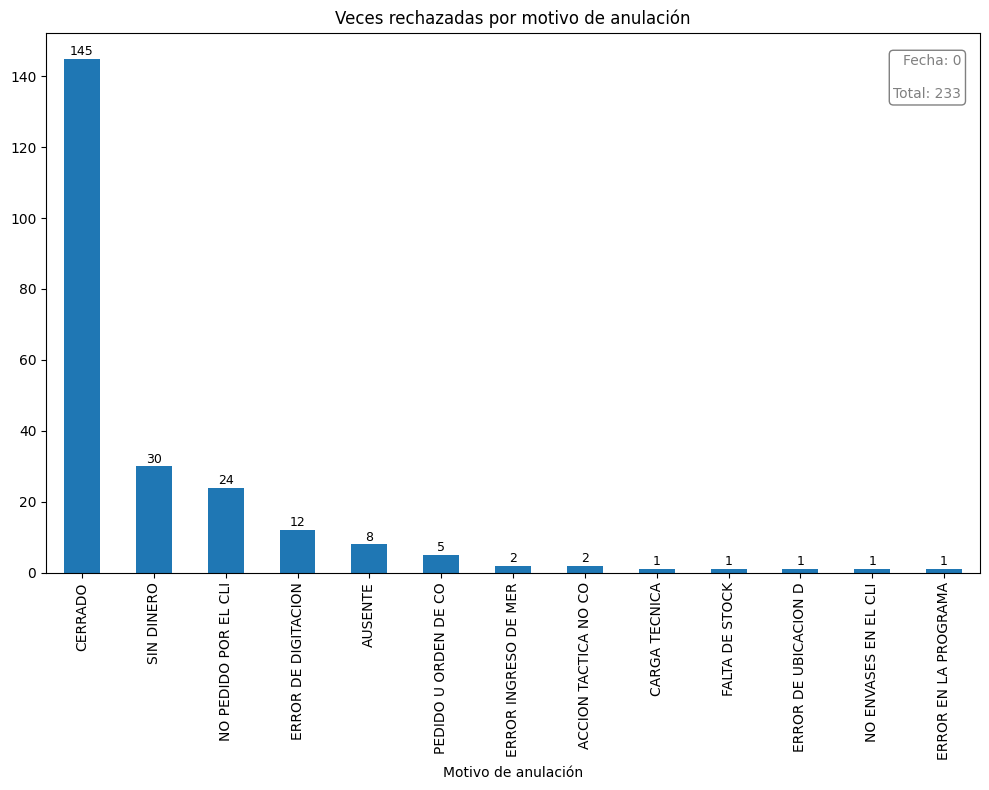

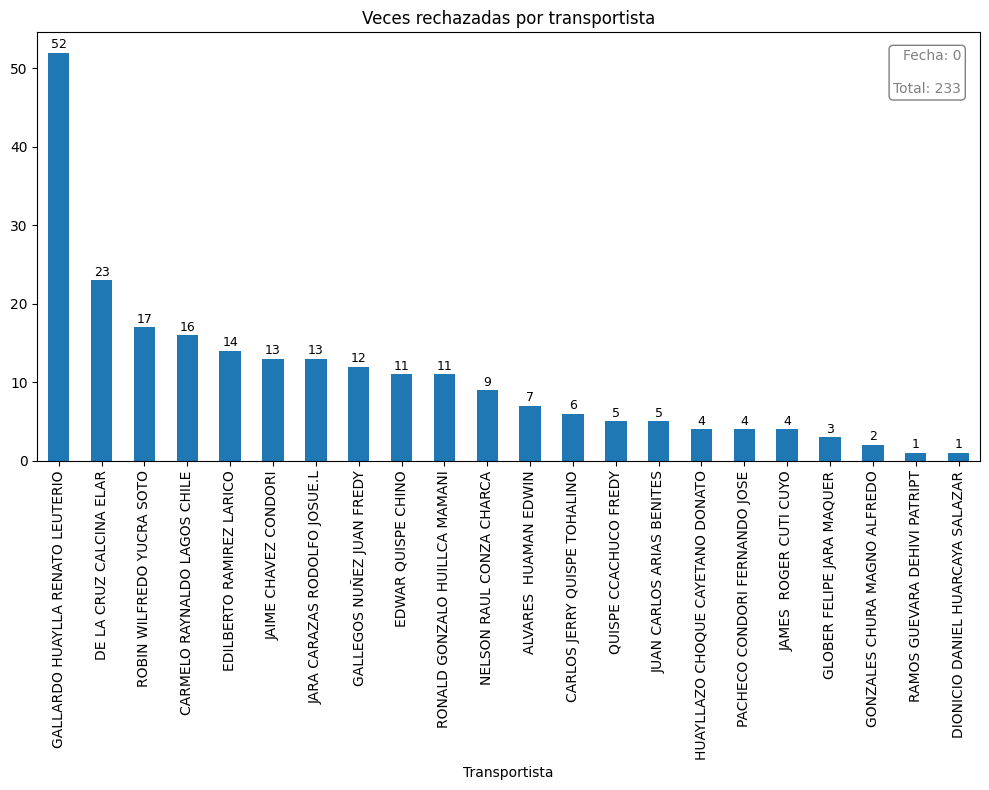

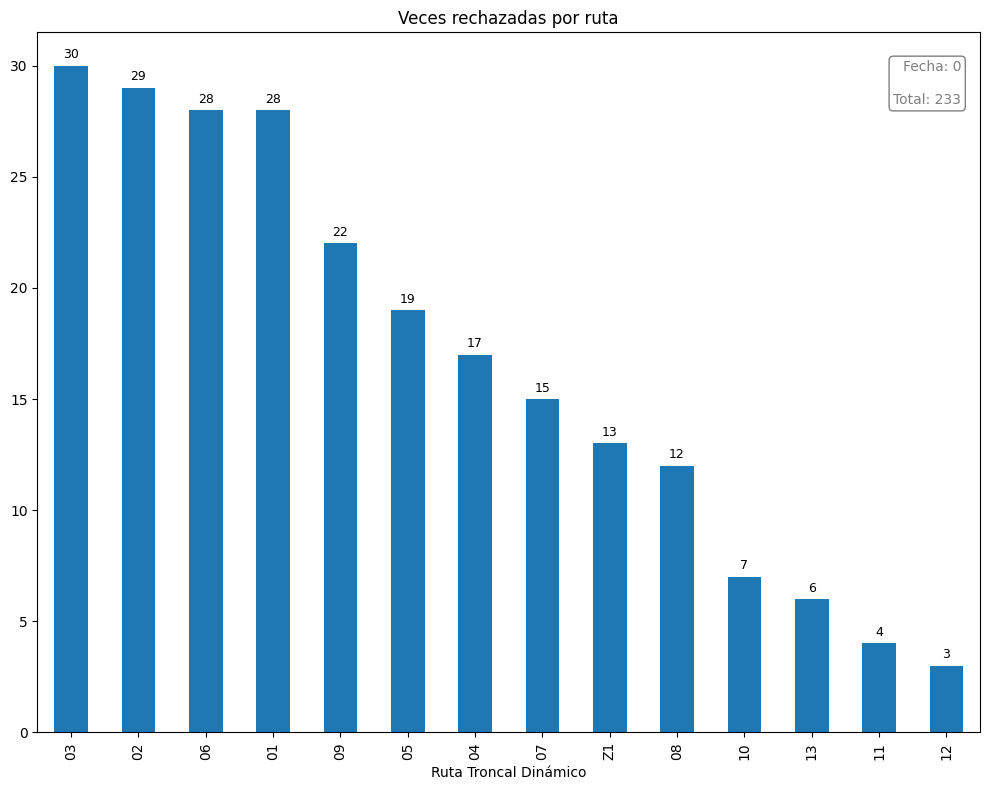

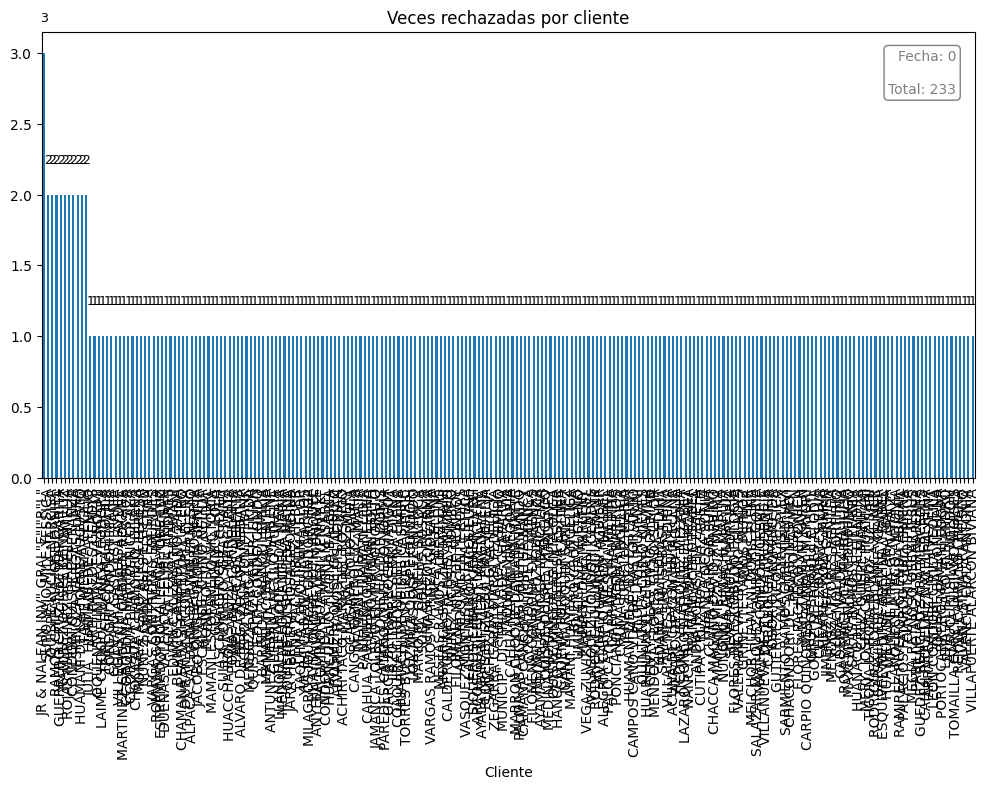

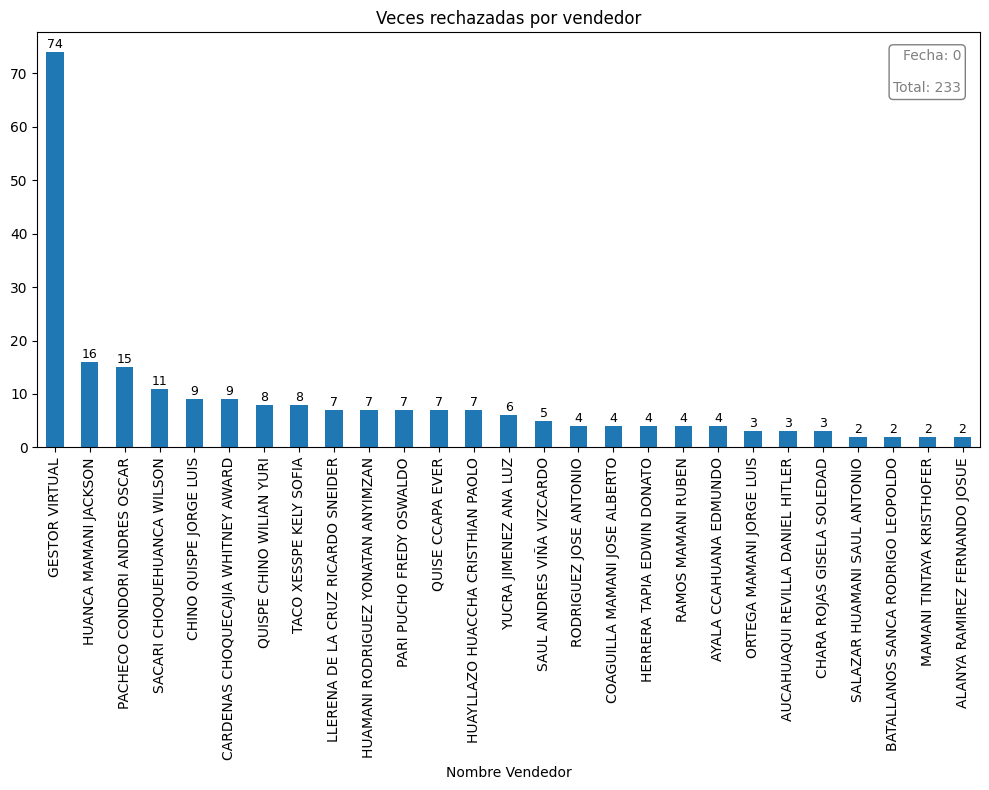

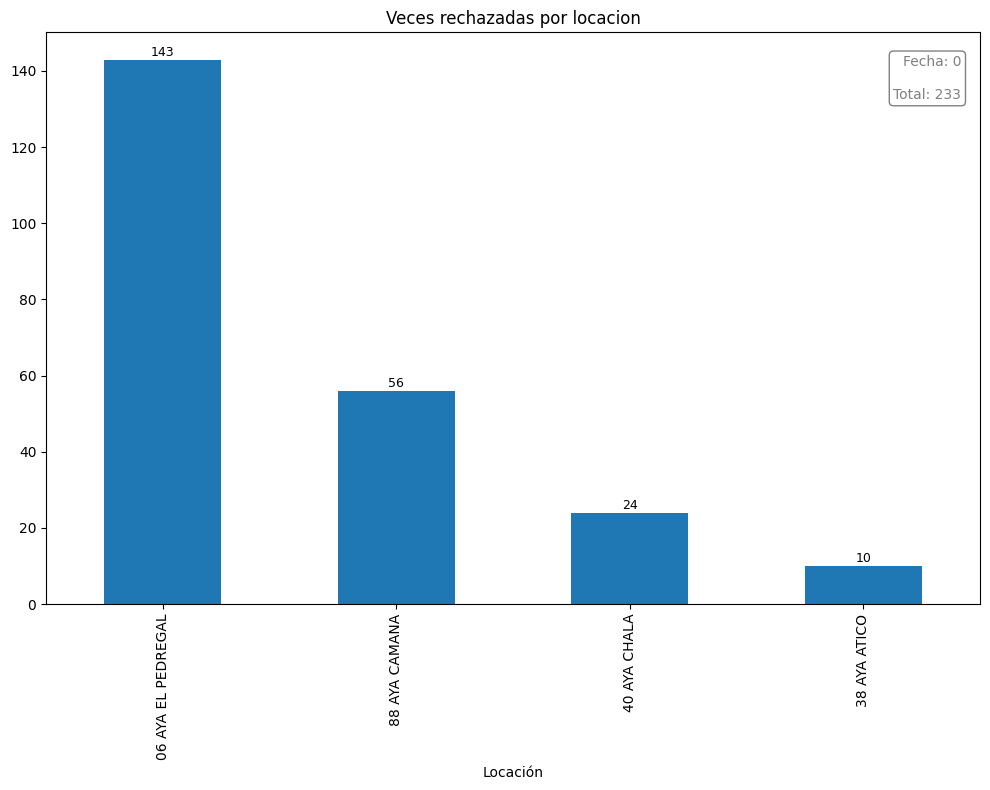

In [ ]:
''' ESCOGER QUE TIPO DE ANALISIS HACER
(1) Por Venta Perdida
(2) Por Cantidad de veces rechazadas
(3) Por Venta perdida y veces rechazadas
(4) Por Venta Perdida (Porcentual)
(5) Por Cantidad de veces rechazadas (Porcentual)
(6) Por Venta perdida y veces rechazadas (Porcentual)
'''

# Seleccionar la opcion de análisis por tiempo
opcion = int(input("(1=VP) (2=VC) (3=VPyVC) (4VP%) (5VC%) (6=VPyVC%)"))

if opcion == 1:
    vc_motivo_anulacion()
    vc_transportista()
    vc_ruta()
    vc_cliente()
    vc_vendedor()
    vc_locacion()

elif opcion == 2:
    vp_motivo_anulacion()
    vp_transportista()
    vp_ruta()
    vp_cliente()
    vp_vendedor()
    vp_locacion()

elif opcion == 3:
    vp_c_motivo_anulacion()
    vp_c_transportista()
    vp_c_ruta()
    vp_c_cliente()
    vp_c_vendedor()
    vp_c_locacion()

elif opcion == 4:
    vp_porcentual_ruta()

elif opcion == 5:
    print()

elif opcion == 6:
    print()